#### Cleaning the pollution dataset

For more details, read 'Multivariate Time Series Forecasting with LSTMs in Keras' (https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/). This LSTM model was trained for 20 epoches.

In [8]:
from datetime import datetime
from pandas import read_csv
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


#### Loading the dataset

In [9]:
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# specify columns to plot
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# Tranform win_dir (labels) to integers
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# Ensure all data is float
values = values.astype('float32')
# Normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled_values = scaler.fit_transform(values)

#### Plotting the data (except win_dir)

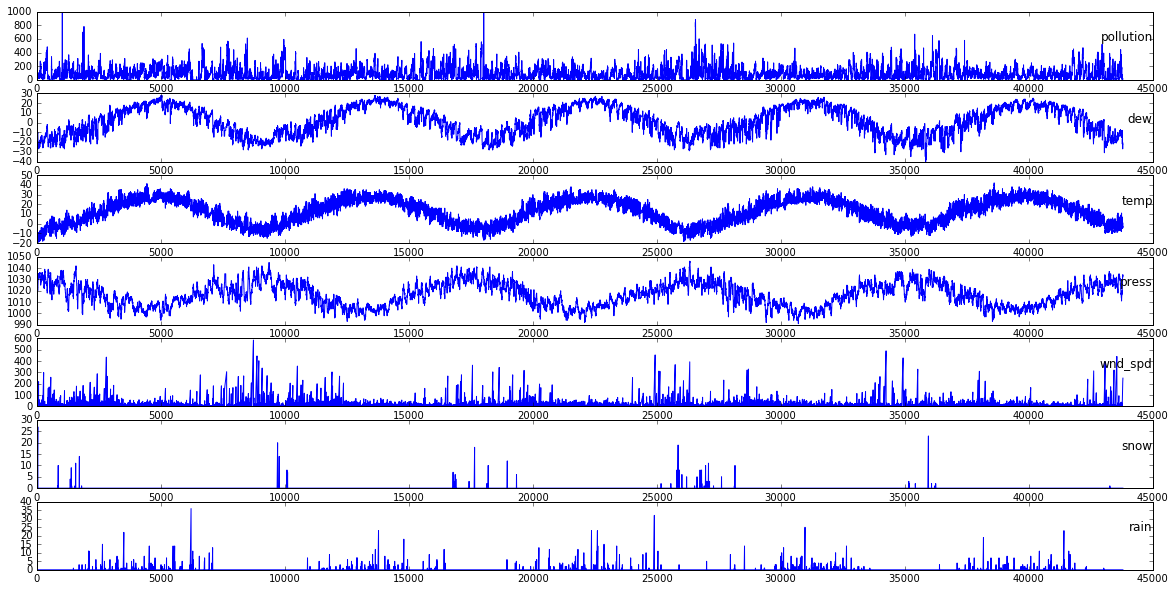

In [10]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(20,10))
for g in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, g])
    pyplot.title(dataset.columns[g], y=0.5, loc='right')
    i += 1
pyplot.show()

#### Splitting the dataset into train and test datasets

In [11]:
dataset_size = values.shape[0]
train_size = int(dataset_size*0.9)
test_size = dataset_size - train_size

print '(Train size, Test size) = ', (train_size, test_size)

train, test = scaled_values[0:train_size], scaled_values[train_size:dataset_size]

print train.shape
print train[0:2]

print values[1]
print values[1][0]

(Train size, Test size) =  (39420, 4380)
(39420, 8)
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]
 [0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
  0.         0.        ]]
[ 148.    -15.     -4.   1020.      2.      2.68    0.      0.  ]
148.0


In [12]:
import numpy as np

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i+look_back)])
        dataY.append(dataset[i+look_back][0])
    return np.array(dataX), np.array(dataY)

#### WIndows of 'look_back' time steps

In [13]:
look_back = 3

trainX, trainY = create_dataset(train, 3)
testX, testY = create_dataset(test, 3)

print 'trainX shape =', trainX.shape
print 'trainY shape =', trainY.shape
print 'testX shape  =', testX.shape
print 'testY shape  =', testY.shape

print trainX[0], '=>', trainY[0]
print trainX[1], '=>', trainY[1]
print trainX[2], '=>', trainY[3]

trainX shape = (39417, 3, 8)
trainY shape = (39417,)
testX shape  = (4377, 3, 8)
testY shape  = (4377,)
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]
 [0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
  0.         0.        ]
 [0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
  0.         0.        ]] => 0.18209255
[[0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
  0.         0.        ]
 [0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
  0.         0.        ]
 [0.18209255 0.48529413 0.22950819 0.5636368  0.6666667  0.00839101
  0.03703704 0.        ]] => 0.13883299
[[0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
  0.         0.        ]
 [0.18209255 0.48529413 0.22950819 0.5636368  0.6666667  0.00839101
  0.03703704 0.        ]
 [0.13883299 0.48529413 0.22950819 0.5636368  0.6666667  0.00991199
  0.07407407 0.        ]] => 0.1056338


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

batch_size = 1
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 8), stateful=True, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 8), stateful=True, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 8), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
for i in range(20):
    print "Epoch No = ", i
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=1, shuffle=False)
    model.reset_states()

Epoch No =  0
Epoch 1/1
39417/39417 [==============================] - 947s 24ms/step - loss: 0.0060 - acc: 0.0502
Epoch No =  1
Epoch 1/1
39417/39417 [==============================] - 778s 20ms/step - loss: 0.0015 - acc: 0.0502
Epoch No =  2
Epoch 1/1
39417/39417 [==============================] - 696s 18ms/step - loss: 0.0012 - acc: 0.0502
Epoch No =  3
Epoch 1/1
39417/39417 [==============================] - 707s 18ms/step - loss: 0.0011 - acc: 0.0502
Epoch No =  4
Epoch 1/1
39417/39417 [==============================] - 711s 18ms/step - loss: 0.0011 - acc: 0.0502
Epoch No =  5
Epoch 1/1
39417/39417 [==============================] - 712s 18ms/step - loss: 0.0011 - acc: 0.0502
Epoch No =  6
Epoch 1/1
39417/39417 [==============================] - 712s 18ms/step - loss: 0.0011 - acc: 0.0502
Epoch No =  7
Epoch 1/1
39417/39417 [==============================] - 725s 18ms/step - loss: 0.0010 - acc: 0.0502
Epoch No =  8
Epoch 1/1
39417/39417 [==============================] - 719s 18ms

In [15]:
train_score = model.evaluate(trainX, trainY, batch_size=1, verbose=1)
print('Train Score: ', train_score)
test_score = model.evaluate(testX, testY, batch_size=1, verbose=1)
print('Test Score: ', test_score)

39417/39417 [==============================] - 54s 1ms/step
('Train Score: ', [0.0012150126568488912, 0.05020676357916635])
4377/4377 [==============================] - 6s 1ms/step
('Test Score: ', [0.0008955433786869364, 0.015078821110349555])


#### Compare predicted values with test dataset

In [18]:
look_ahead = testX.shape[0]

predictions = np.zeros((look_ahead,1))

for i in range(look_ahead):
    prediction = model.predict(np.array([testX[i]]), batch_size=1)
    predictions[i] = prediction
    
print predictions[0]

[0.05612999]


##### Plot of whole test dataset and the predicted values

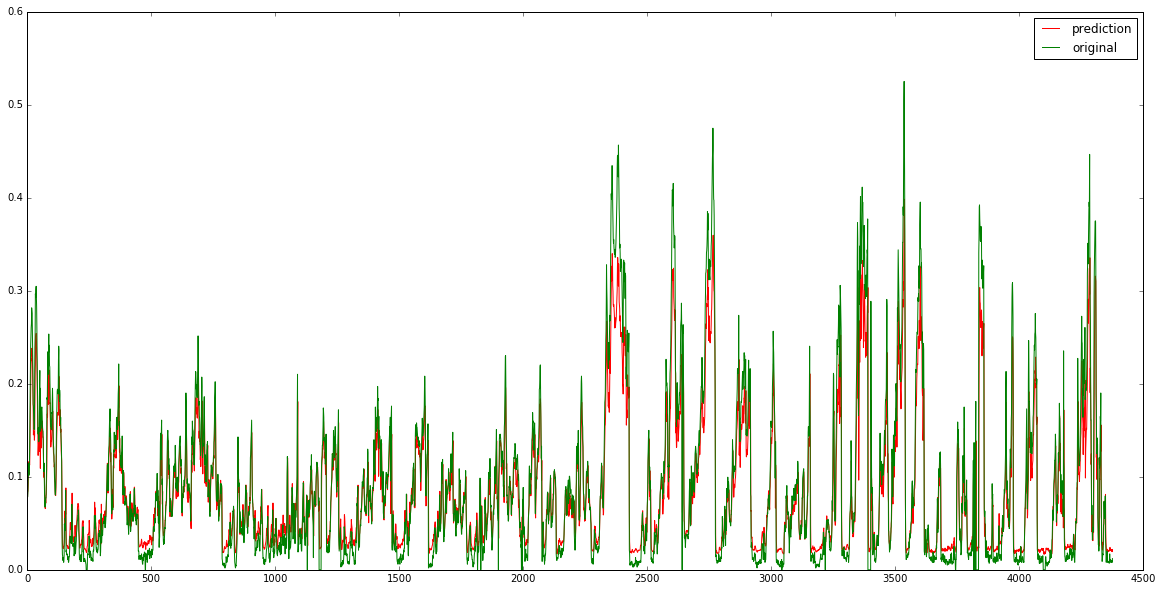

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),testY,'g',label="original")
plt.legend()
plt.show()

##### Plot of first 200 data points of the test dataset and the predicted values

In [33]:
orig = np.zeros(200)
pred = np.zeros(200)
for i in range(200):
    orig[i] = testY[i]
    pred[i] = predictions[i]

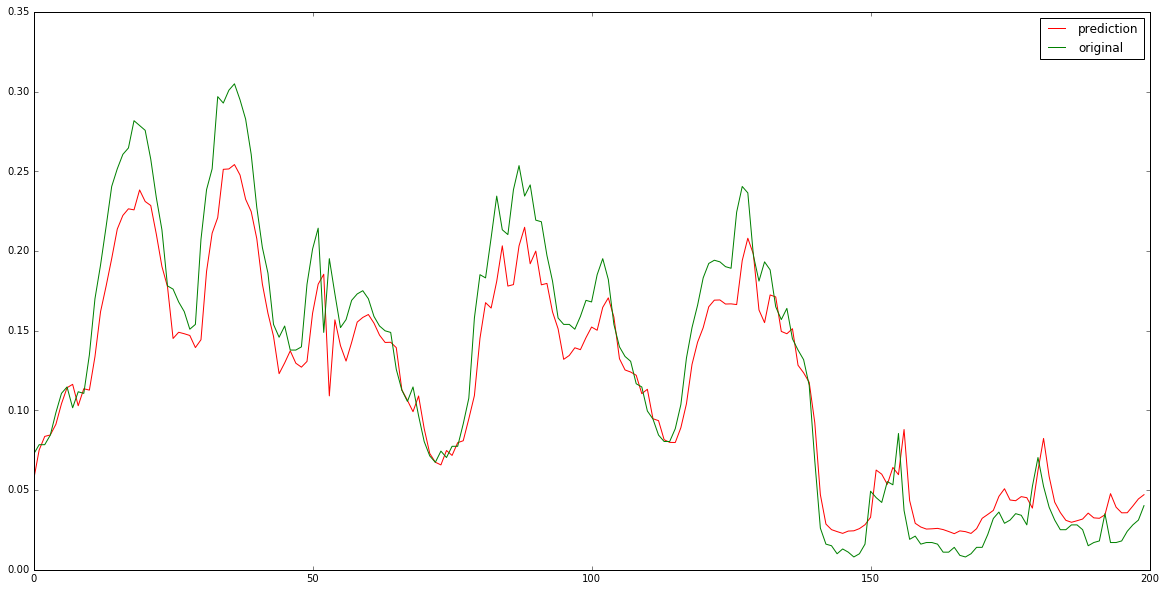

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(np.arange(200),pred,'r',label="prediction")
plt.plot(np.arange(200),orig,'g',label="original")
plt.legend()
plt.show()